In [1]:
#Importing
#!conda install geopandas --y

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import tensorflow as tf
import geopandas as gpd

from shapely.geometry import Point

from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score)
from sklearn.feature_selection import RFECV, mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from scikeras.wrappers import KerasClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding
from tensorflow.keras.utils import to_categorical

In [2]:
#Importing Data
data = pd.read_csv("data/ACLED2021-2024.csv")

location_data = data.copy()

data.drop(columns=['time_precision', 'assoc_actor_1', 'assoc_actor_2', 'iso', 'region', 'admin3', 'location', 
                  'latitude', 'longitude', 'geo_precision', 'source_scale', 'timestamp', 'tags', 'population_best', 'event_id_cnty'], 
          inplace=True)

print(data.shape)


data['event_date'] = pd.to_datetime(data['event_date'], errors = 'coerce') #changing to datetime

#data.set_index('event_date', inplace=True)
#data.index = pd.to_datetime(data.index)
data.sort_index(inplace=True)

print(data.shape)
#data = data.dropna(subset=['event_date'])

(38130, 17)
(38130, 17)


In [3]:
# Dropping Dupes
initial_row_count = data.shape[0]
data = data.drop_duplicates()
final_row_count = data.shape[0]
print(f"Removed {initial_row_count - final_row_count} duplicates")
print(data.shape)

Removed 40 duplicates
(38090, 17)


In [4]:
#Reformatting / Cleaning

#Addressing NA values - Categorical, NUmerical and date
categorical_columns = ['disorder_type', 'event_type', 'sub_event_type', 'actor1', 'actor2', 'civilian_targeting', 
                       'country', 'admin1', 'admin2', 'source', 'notes']
categorical_columns = data[categorical_columns]


for column in categorical_columns:
    data[column] = data[column].fillna('Not specified')

numerical_columns = ['fatalities', 'inter1', 'inter2', 'interaction']

for column in numerical_columns:
    data[column] = data[column].fillna(data[column].median()) #using median to fill
    
#print(data.isna().sum())
print(data.shape)
#data.loc[:, 'actor2'] = data['actor2'].fillna('Not specified')
#data.loc[:, 'civilian_targeting'] = data['civilian_targeting'].fillna('Not specified')

(38090, 17)


In [5]:
#Grouping Together Actor1 and 2
def consolidate_names(name):
    if 'Military Forces of Israel' in name:
        return 'Military Forces of Israel'
    elif 'Police Forces of Israel' in name:
        return 'Police Forces of Israel'
    elif 'Hamas Movement' in name:
        return 'Hamas Movement'
    elif 'Police Forces of Israel' in name or 'Government of Israel' in name:
        return 'Government and Police Forces of Israel'
    elif 'Police Forces of Palestine' in name or 'Government of Palestine' in name:
        return 'Government and Police Forces of Palestine'
    elif 'PIJ:' in name or 'Islamic Jihad' in name:
        return 'Palestinian Islamic Jihad'
    elif 'Hezbollah' in name:
        return 'Hezbollah'
    elif 'Al Aqsa' in name:
        return 'Al Aqsa Martyrs Brigade'
    elif 'Katibat' in name:
        return 'Katibat Groups (Palestine)'
    elif 'PFLP:' in name:
        return 'Popular Front for the Liberation of Palestine'
    elif 'DFLP:' in name:
        return 'Democratic Front for the Liberation of Palestine'
    elif 'Military Forces of Iran' in name:
        return 'Iranian Revolutionary Guard Corps'
    elif 'Islamic State' in name:
        return 'Islamic State'
#civilians
    elif 'Civilians' in name:
        if 'Israel' in name or 'Palestine' in name:
            return name  #Keeping isr and pal civilians
        else:
            return 'Civilians (International)'  # grouping others as int.
#armed groups
    elif 'Unidentified Armed Group' in name:
        if 'Israel' in name or 'Palestine' in name:
            return name  
        else:
            return 'Unidentified Armed Group (International)'
#military forces
    elif 'Military Forces of' in name:
        if 'Israel' in name or 'Palestine' in name:
            return name  
        else:
            return 'Military Forces of International Forces'
    elif 'Settlers' in name:
        return 'Settlers (Israel)'
    elif 'Protesters' in name or 'Rioters' in name:
        return name  # Retains specific categories due to their distinct contexts
    else:
        return name #'Other Groups' 

# Apply the consolidation function to both actor1 and actor2
data['actor1_grouped'] = data['actor1'].apply(consolidate_names)
data['actor2_grouped'] = data['actor2'].apply(consolidate_names)

In [6]:
#Grouping smaller entities
actor1_counts = data['actor1_grouped'].value_counts()
actor2_counts = data['actor2_grouped'].value_counts()

def consolidate_small_groups(name, counts): #Check if Isr or Pal if not 'name'
    if counts[name] < 10:
        if 'Israel' in name:
            return 'Other (Israel)'
        elif 'Palestine' in name:
            return 'Other (Palestine)'
        else:
            return'Other Group'
    else:
        # Return the name if the count is 10 or more
        return name

# Apply the consolidation function to both actor1_grouped and actor2_grouped
data['actor1_grouped'] = data['actor1_grouped'].apply(lambda x: consolidate_small_groups(x, actor1_counts))
data['actor2_grouped'] = data['actor2_grouped'].apply(lambda x: consolidate_small_groups(x, actor2_counts))


# Print the new value counts to confirm re-categorization
#print(data['actor1_grouped'].value_counts())
#print(data['actor2_grouped'].value_counts())

data['actor1'] = data['actor1_grouped']
data['actor2'] = data['actor2_grouped']

data.drop(['actor1_grouped', 'actor2_grouped'], axis=1, inplace=True)
print(data.isna().sum())
# calculate the percentage of zero values per column
zero_counts = (data == 0).astype(int).sum(axis=0)
zero_percentage = 100 * zero_counts / len(data)

# display the columns with high percentages of zeros
print("Percentage of zeros in each column:")
print(zero_percentage[zero_percentage > 0])  # Adjust the threshold as necessary


event_date            0
year                  0
disorder_type         0
event_type            0
sub_event_type        0
actor1                0
inter1                0
actor2                0
inter2                0
interaction           0
civilian_targeting    0
country               0
admin1                0
admin2                0
source                0
notes                 0
fatalities            0
dtype: int64
Percentage of zeros in each column:
inter2        27.274875
fatalities    91.047519
dtype: float64


In [7]:
#Creating Temporal Features for T-S

#Date related
data['year'] = data['event_date'].dt.year
data['month'] = data['event_date'].dt.month
data['day'] = data['event_date'].dt.day
data['day_of_week'] = data['event_date'].dt.day_name()
data['days_since_start'] = (data['event_date'] - data['event_date'].min()).dt.days

# time since last event of the same type
data['time_since_last_event'] = data.groupby('event_type')['event_date'].diff().dt.days
#data['time_since_last_event'] = data.groupby('event_type').apply(lambda x: x.index.to_series().diff().dt.days).reset_index(level=0, drop=True)


# time since last disorder of the same type
data['time_since_last_disorder'] = data.groupby('disorder_type')['event_date'].diff().dt.days
#data['time_since_last_disorder'] = data.groupby('disorder_type').apply(lambda x: x.index.to_series().diff().dt.days).reset_index(level=0, drop=True)
#print(data[['time_since_last_event', 'time_since_last_disorder']].head())


# rolling avg for fatalities
data['rolling_avg_fatalities_7d'] = data.groupby(
    'event_type')['fatalities'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())


# cumulative counts of events and fatalities by specific features
data['cumulative_events'] = data.groupby(['event_type']).cumcount() + 1
data['cumulative_fatalities'] = data.groupby(['event_type'])['fatalities'].cumsum()

log_data = data.copy()


In [8]:
#All data cleaning steps on LOCATION DATA
location_data['event_date'] = pd.to_datetime(location_data['event_date'], errors='coerce')  # Convert to datetime

location_data.sort_index(inplace=True)

# Drop duplicates and record the count before and after
initial_row_count = location_data.shape[0]
location_data.drop_duplicates(inplace=True)
final_row_count = location_data.shape[0]

# Fill missing categorical data
categorical_columns = ['disorder_type', 'event_type', 'sub_event_type', 'actor1', 'actor2', 'civilian_targeting', 
                       'country', 'admin1', 'admin2', 'source', 'notes']
for column in categorical_columns:
    location_data[column] = location_data[column].fillna('Not specified')
    
# Fill missing numerical data
numerical_columns = ['fatalities', 'inter1', 'inter2', 'interaction', 'longitude', 'latitude']
for column in numerical_columns:
    location_data[column] = location_data[column].fillna(location_data[column].median())

# Assume consolidate_names is a function that's already defined
location_data['actor1_grouped'] = location_data['actor1'].apply(consolidate_names)
location_data['actor2_grouped'] = location_data['actor2'].apply(consolidate_names)

# Calculate value counts for grouped actors
actor1_counts = location_data['actor1_grouped'].value_counts()
actor2_counts = location_data['actor2_grouped'].value_counts()

# Assume consolidate_small_groups is a function that's already defined
# Apply consolidation function based on counts
location_data['actor1_grouped'] = location_data['actor1_grouped'].apply(lambda x: consolidate_small_groups(x, actor1_counts))
location_data['actor2_grouped'] = location_data['actor2_grouped'].apply(lambda x: consolidate_small_groups(x, actor2_counts))

# Update the 'actor1' and 'actor2' columns
location_data['actor1'] = location_data['actor1_grouped']
location_data['actor2'] = location_data['actor2_grouped']

# Drop the temporary grouped columns
location_data.drop(['actor1_grouped', 'actor2_grouped'], axis=1, inplace=True)

<Figure size 1500x800 with 0 Axes>

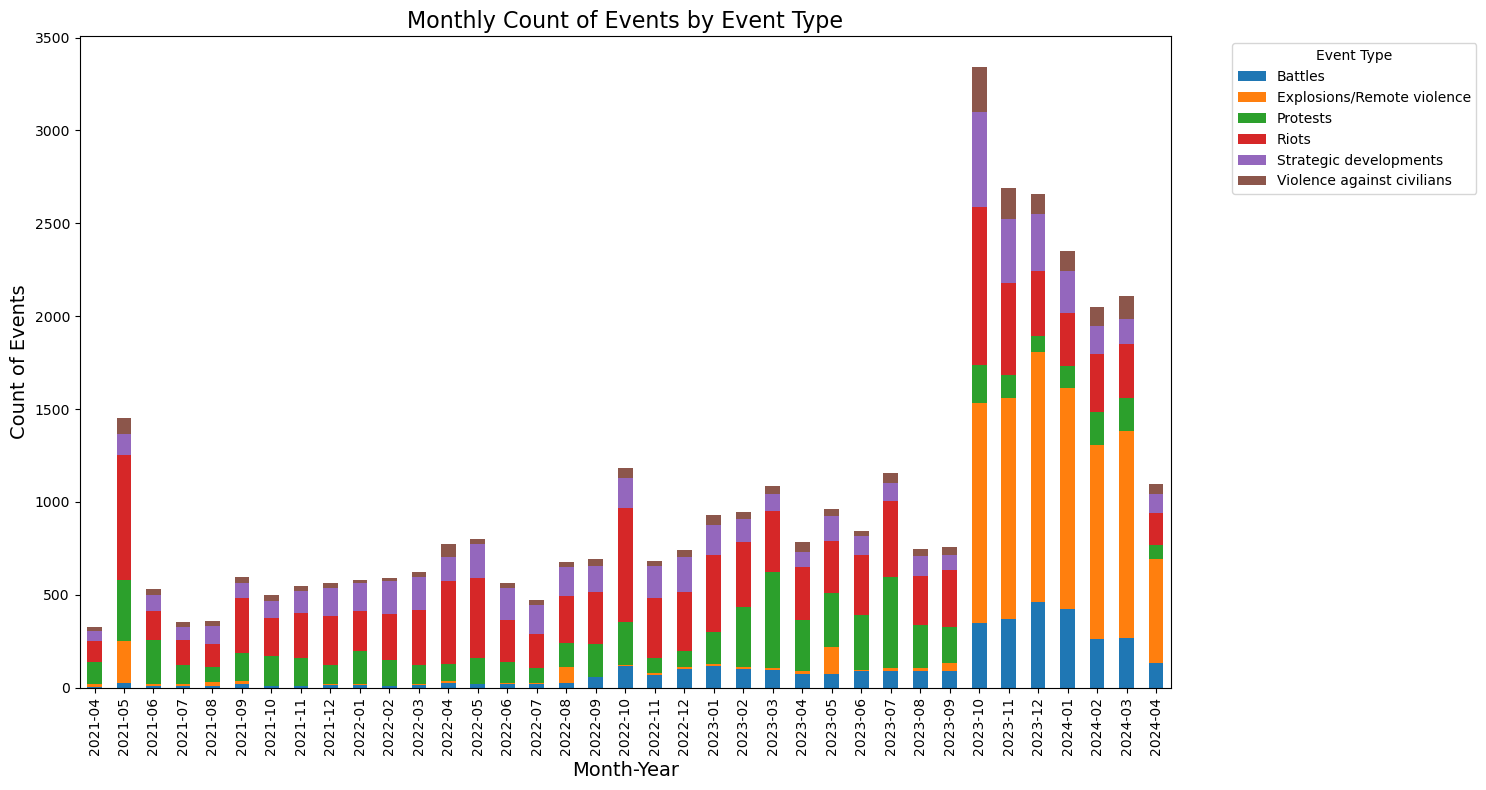

In [9]:
# Plotting the count of events over time by event_type
data['month_year'] = data['event_date'].dt.to_period('M') #group data into month

# countplot with monthly data
plt.figure(figsize=(15, 8))
monthly_data = data.groupby(['month_year', 'event_type']).size().reset_index(name='counts')

#creating'event_type' columns
monthly_pivot = monthly_data.pivot(index='month_year', columns='event_type', values='counts').fillna(0)

monthly_pivot.plot(kind='bar', stacked=True, figsize=(15, 8))
plt.title('Monthly Count of Events by Event Type', fontsize=16)
plt.xlabel('Month-Year', fontsize=14)
plt.ylabel('Count of Events', fontsize=14)
plt.xticks(rotation=90)
plt.legend(title='Event Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

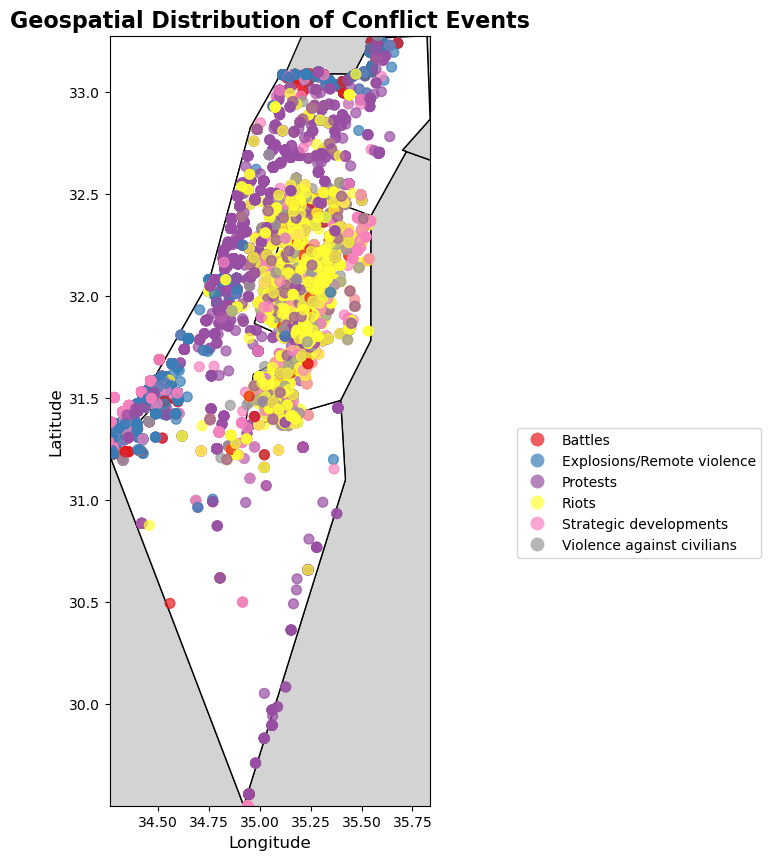

In [77]:
geometry = [Point(xy) for xy in zip(location_data.longitude, location_data.latitude)]
geo_df = gpd.GeoDataFrame(location_data, geometry=geometry)

fig, ax = plt.subplots(1, 1, figsize=(5, 10))

# Load a world map shapefile and plot the world in a light grey
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot Israel and Palestine with a clear edge
isr_pal = world[(world.name == "Israel") | (world.name == "Palestine")]
isr_pal.plot(ax=ax, color='white', edgecolor='black')

geo_df.plot(ax=ax, column='event_type', legend=True, markersize=50, cmap='Set1', alpha=0.7)

leg = ax.get_legend()
if leg:  
    leg.set_bbox_to_anchor((1.25, 0.5))

# Set the limits to frame the region of interest
plt.xlim(isr_pal.bounds.minx.min(), isr_pal.bounds.maxx.max())
plt.ylim(isr_pal.bounds.miny.min(), isr_pal.bounds.maxy.max())

# Set title and axis labels
plt.title('Geospatial Distribution of Conflict Events', fontsize=16, weight='bold')
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

# Remove axis for a cleaner look
plt.axis('on')

# Show the plot
plt.show()

In [11]:
#log transformations
log_columns = ['fatalities', 'cumulative_events', 'cumulative_fatalities', 'rolling_avg_fatalities_7d', 
               'time_since_last_event', 'time_since_last_disorder', 'days_since_start']
for col in log_columns:
    log_data['log_' + col] = np.log1p(log_data[col])

# creating lagged features
for col in log_columns:
    log_col = 'log_' + col
    for lag in [1, 2, 3]:
        log_data[f'{log_col}_lag{lag}'] = log_data[log_col].shift(lag)

/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [12]:
log_data

,event_date,year,disorder_type,event_type,sub_event_type,actor1,inter1,actor2,inter2,interaction,...,log_rolling_avg_fatalities_7d_lag3,log_time_since_last_event_lag1,log_time_since_last_event_lag2,log_time_since_last_event_lag3,log_time_since_last_disorder_lag1,log_time_since_last_disorder_lag2,log_time_since_last_disorder_lag3,log_days_since_start_lag1,log_days_since_start_lag2,log_days_since_start_lag3
0,2024-04-19,2024,Political violence,Explosions/Remote violence,Shelling/artillery/missile attack,Hamas Movement,3,Not specified,0,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-04-19,2024,Demonstrations,Protests,Peaceful protest,Protesters (Israel),6,Not specified,0,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.999422,NaN,NaN
2,2024-04-19,2024,Demonstrations,Riots,Violent demonstration,Rioters (Israel),5,Rioters (Israel),5,55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.999422,6.999422,NaN
3,2024-04-19,2024,Demonstrations,Protests,Peaceful protest,Protesters (Israel),6,Not specified,0,60,...,0.0,NaN,NaN,NaN,0.0,NaN,NaN,6.999422,6.999422,6.999422
4,2024-04-19,2024,Political violence,Battles,Armed clash,Hezbollah,3,Military Forces of Israel,1,13,...,0.0,0.0,NaN,NaN,0.0,0.0,NaN,6.999422,6.999422,6.999422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38125,2021-04-20,2021,Strategic developments,Strategic developments,Other,Military Forces of Israel,8,Civilians (Palestine),7,78,...,0.0,0.0,-inf,0.0,0.0,-inf,0.0,0.000000,0.000000,0.000000
38126,2021-04-20,2021,Political violence,Riots,Mob violence,Rioters (Israel),5,Not specified,0,50,...,0.0,0.0,0.0,-inf,0.0,0.0,-inf,0.000000,0.000000,0.000000
38127,2021-04-20,2021,Demonstrations,Protests,Peaceful protest,Protesters (Palestine),6,Not specified,0,60,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
38128,2021-04-20,2021,Political violence,Riots,Mob violence,Rioters (Israel),5,Civilians (Palestine),7,57,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000


In [13]:
print(log_data.isna().sum())

# percentage of zero values
zero_counts = (log_data == 0).astype(int).sum(axis=0)
zero_percentage = 100 * zero_counts / len(log_data)
print(zero_percentage[zero_percentage > 0])


event_date                              0
year                                    0
disorder_type                           0
event_type                              0
sub_event_type                          0
actor1                                  0
inter1                                  0
actor2                                  0
inter2                                  0
interaction                             0
civilian_targeting                      0
country                                 0
admin1                                  0
admin2                                  0
source                                  0
notes                                   0
fatalities                              0
month                                   0
day                                     0
day_of_week                             0
days_since_start                        0
time_since_last_event                   6
time_since_last_disorder                4
rolling_avg_fatalities_7d         

In [14]:
#replacing infinities w NaN
log_data.replace([np.inf, -np.inf], np.nan, inplace=True)
#log_data.fillna(log_data.median(), inplace=True)

#median for numeric columns
numeric_medians = log_data.select_dtypes(include=[np.number]).median()
log_data.fillna(numeric_medians, inplace=True)


log_data['time_since_last_event'].fillna(method='ffill', inplace=True)
log_data['time_since_last_event'].fillna(method='bfill', inplace=True)

lag_cols = [col for col in log_data.columns if ('log_time_since_last_event' in col or 'lag' in col) and 
            np.issubdtype(log_data[col].dtype, np.number)]

In [15]:
print(log_data.shape)
print(log_data.isna().sum())

# percentage of zero values
zero_counts = (log_data == 0).astype(int).sum(axis=0)
zero_percentage = 100 * zero_counts / len(log_data)
print(zero_percentage[zero_percentage > 0])

(38090, 54)
event_date                            0
year                                  0
disorder_type                         0
event_type                            0
sub_event_type                        0
actor1                                0
inter1                                0
actor2                                0
inter2                                0
interaction                           0
civilian_targeting                    0
country                               0
admin1                                0
admin2                                0
source                                0
notes                                 0
fatalities                            0
month                                 0
day                                   0
day_of_week                           0
days_since_start                      0
time_since_last_event                 0
time_since_last_disorder              0
rolling_avg_fatalities_7d             0
cumulative_events           

In [16]:
#Encoding

#One-Hot for Categoricals
categorical_cols = ['disorder_type', 'event_type', 'actor1', 'actor2', 'civilian_targeting',
                    'country', 'admin1', 'admin2', 'day_of_week']
log_data_encoded = pd.get_dummies(log_data, columns=categorical_cols)
log_data_encoded

#Label Encoder
label_encoders = {}

for col in ['inter1', 'inter2', 'interaction', 'sub_event_type']:
    le = LabelEncoder()
    log_data_encoded[col] = le.fit_transform(log_data_encoded[col])
    label_encoders[col] = le  # storing the encoder
#log_data_encoded.to_csv('data/log_data_encoded.csv', index=False)
#print(log_data_encoded.isna().sum())

In [17]:
log_data_encoded

,event_date,year,sub_event_type,inter1,inter2,interaction,source,notes,fatalities,month,...,admin2_Tulkarm,admin2_Yizreel,admin2_Zefat,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,2024-04-19,2024,18,2,0,9,N12; Times of Israel,"Interception: On 19 April 2024, Hamas militant...",0,4,...,False,False,False,True,False,False,False,False,False,False
1,2024-04-19,2024,15,5,0,21,Ynet,"On 19 April 2024, thousands formed a human cha...",0,4,...,False,False,False,True,False,False,False,False,False,False
2,2024-04-19,2024,19,4,4,17,Haaretz; Jerusalem Post; N12; Times of Israel;...,"On 19 April 2024, dozens of relatives of hosta...",0,4,...,False,False,False,True,False,False,False,False,False,False
3,2024-04-19,2024,15,5,0,21,Ynet,"On 19 April 2024, thousands formed a human cha...",0,4,...,False,False,False,True,False,False,False,False,False,False
4,2024-04-19,2024,3,2,1,3,Jerusalem Post; Ma'ariv; Times of Israel,"On 19 April 2024, Hezbollah forces in Lebanon ...",0,4,...,False,False,True,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38125,2021-04-20,2021,14,7,6,26,PLO Negotiations Affairs Department,"Other: On 20 April 2021, Israeli military forc...",0,4,...,False,False,False,False,False,False,False,False,True,False
38126,2021-04-20,2021,12,4,0,16,PLO Negotiations Affairs Department,"On 20 April 2021, Israeli settlers uprooted 20...",0,4,...,False,False,False,False,False,False,False,False,True,False
38127,2021-04-20,2021,15,5,0,21,Ma'an News Agency,"On 20 April 2021, a large protest organized by...",0,4,...,False,False,False,False,False,False,False,False,True,False
38128,2021-04-20,2021,12,4,6,19,PLO Negotiations Affairs Department,"On 20 April 2021, Israeli settlers from the Ba...",0,4,...,False,False,False,False,False,False,False,False,True,False


In [18]:
# Correlation Analysis for numerical cols
numerical_cols = log_data_encoded.select_dtypes(include=['int64', 'float64']).columns
numerical_data = log_data_encoded[numerical_cols]
correlation_matrix = numerical_data.corr()

threshold = 0.85
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool_))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
to_drop

['interaction',
 'log_rolling_avg_fatalities_7d',
 'log_days_since_start',
 'log_days_since_start_lag1',
 'log_days_since_start_lag2',
 'log_days_since_start_lag3']

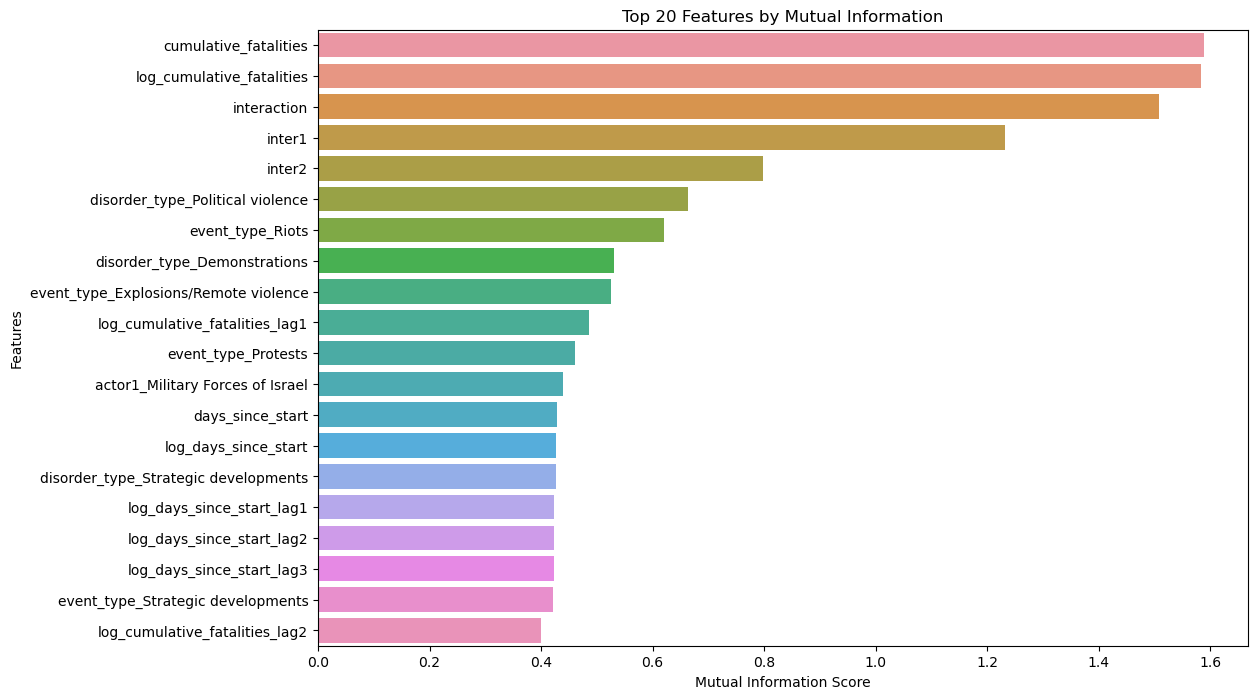

In [19]:
#Mututal Information features

target = 'sub_event_type'

# taking out the text + datetime
features = log_data_encoded.drop(columns=[target, 'event_date', 'source', 'notes'])

# actual mi score calculation
mi_scores = mutual_info_classif(features, log_data_encoded[target], discrete_features='auto')

# putting in df
mi_df = pd.DataFrame({'Feature': features.columns, 'MI_Score': mi_scores})
mi_df.sort_values('MI_Score', ascending=False, inplace=True)

plt.figure(figsize=(12, 8))
sns.barplot(x='MI_Score', y='Feature', data=mi_df.sort_values('MI_Score', ascending=False).head(20))
plt.title('Top 20 Features by Mutual Information')
plt.xlabel('Mutual Information Score')
plt.ylabel('Features')
plt.show()

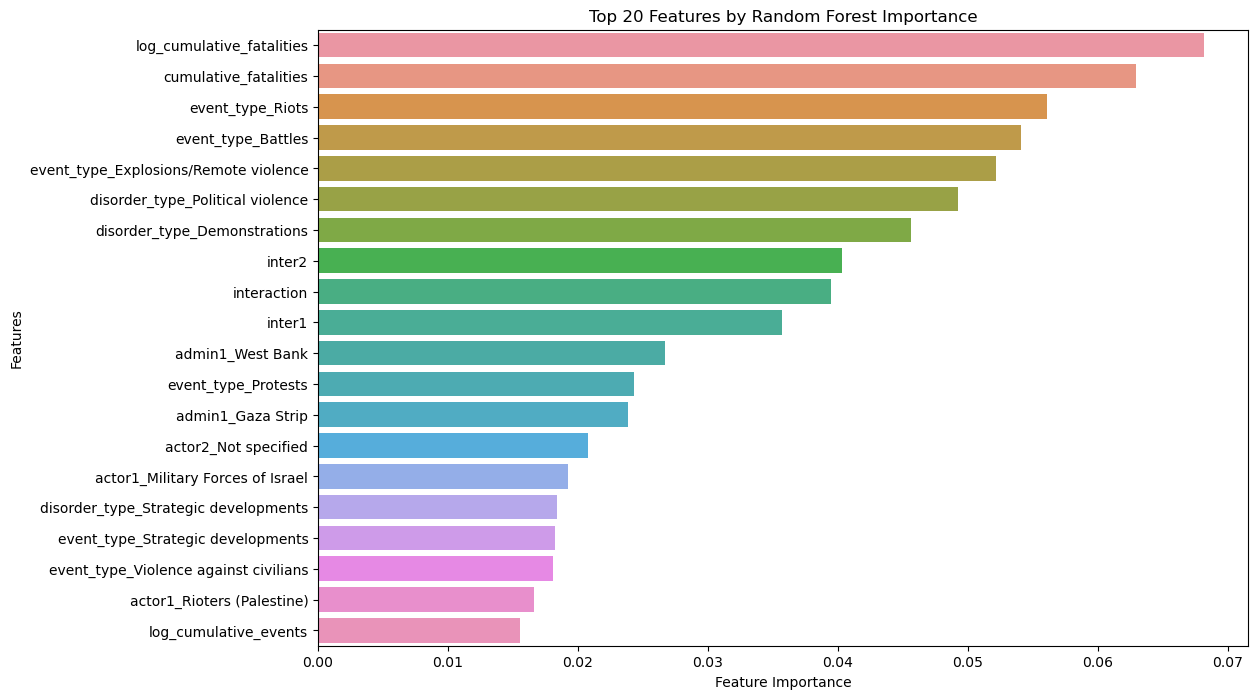

In [20]:
#Random Forest Importance
#numeric_encoded_log_data
#Dropping numeric + T/T Splitting
X = log_data_encoded.drop(['sub_event_type',  'event_date', 'source', 'notes'], axis=1)
y = log_data_encoded['sub_event_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

forest = RandomForestClassifier(random_state=42)
forest.fit(X_train, y_train)

# feature importances into df
importances = forest.feature_importances_

rf_df = pd.DataFrame({'Feature': X_train.columns, 'RF_Importance': importances})
rf_df.sort_values('RF_Importance', ascending=False, inplace=True)

plt.figure(figsize=(12, 8))
sns.barplot(x='RF_Importance', y='Feature', data=rf_df.sort_values('RF_Importance', ascending=False).head(20))
plt.title('Top 20 Features by Random Forest Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show()

In [21]:
print(mi_df.shape)
print(rf_df.shape)

(151, 2)
(151, 2)


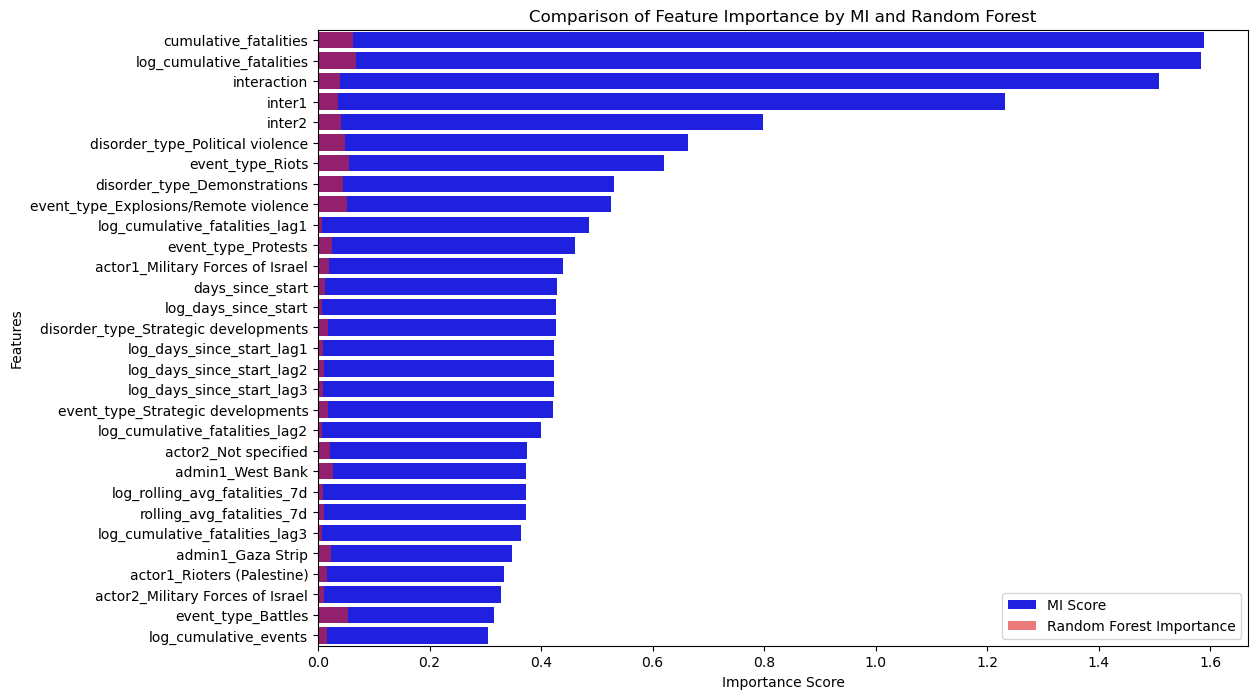

In [22]:
rf_df = pd.DataFrame({'Feature': X_train.columns,
                                    'RF_Importance': forest.feature_importances_})

#merging datasets
combined_importances = pd.merge(mi_df, rf_df, on='Feature', how='outer')

combined_importances.sort_values(by='MI_Score', ascending=False, inplace=True)

combined_importances = pd.merge(mi_df, rf_df, on='Feature', how='outer')

#set the amount of feaatures
sorted_idx = combined_importances.sort_values(by='MI_Score', ascending=False)['Feature'].head(30)


plt.figure(figsize=(12, 8))
sns.barplot(x='MI_Score', y='Feature', data=combined_importances[combined_importances['Feature'].isin(sorted_idx)], 
            color='blue', label='MI Score')
sns.barplot(x='RF_Importance', y='Feature', data=combined_importances[combined_importances['Feature'].isin(sorted_idx)], 
            color='red', alpha=0.6, label='Random Forest Importance')
plt.title('Comparison of Feature Importance by MI and Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.legend()
plt.show()


In [23]:
# MI score
mi_percentile = 70  # aka keeping top 50%
mi_threshold = np.percentile(mi_df['MI_Score'], mi_percentile)
#top_mi_features = mi_df[mi_df['MI_Score'] >= mi_threshold]
selected_mi_features = mi_df[mi_df['MI_Score'] >= mi_threshold]['Feature'].tolist()
#top_mi_features.shape
#print(selected_mi_features)

# random forest importance
rf_percentile = 70  # aka keeping top 50% | top 30% is 43 features
rf_threshold = np.percentile(rf_df['RF_Importance'], rf_percentile)
#top_rf_features = rf_df[rf_df['RF_Importance'] >= rf_threshold]
selected_rf_features = rf_df[rf_df['RF_Importance'] >= 
                                      rf_threshold]['Feature'].tolist()
#top_rf_features.shape
#print(selected_rf_features)

#Combining into 1
selected_features = list(set(selected_mi_features) & set(selected_rf_features))

In [24]:
print(selected_features)

['log_days_since_start_lag3', 'disorder_type_Strategic developments', 'log_days_since_start', 'country_Palestine', 'log_cumulative_events_lag3', 'log_days_since_start_lag2', 'log_cumulative_fatalities_lag3', 'actor1_Military Forces of Israel', 'actor1_Rioters (Palestine)', 'log_cumulative_events', 'interaction', 'log_cumulative_events_lag2', 'disorder_type_Political violence', 'event_type_Explosions/Remote violence', 'inter2', 'civilian_targeting_Civilian targeting', 'rolling_avg_fatalities_7d', 'cumulative_fatalities', 'event_type_Riots', 'event_type_Strategic developments', 'log_cumulative_fatalities_lag2', 'actor2_Military Forces of Israel', 'disorder_type_Demonstrations', 'log_cumulative_events_lag1', 'event_type_Protests', 'admin1_Gaza Strip', 'days_since_start', 'civilian_targeting_Not specified', 'log_rolling_avg_fatalities_7d', 'inter1', 'fatalities', 'log_rolling_avg_fatalities_7d_lag1', 'log_cumulative_fatalities', 'event_type_Violence against civilians', 'admin1_West Bank', 

In [25]:
print(len(selected_features))
print(len(set(selected_features))) #unique


43
43


In [26]:
log_data_encoded = log_data_encoded.apply(lambda col: col.astype(int) if pd.api.types.is_bool_dtype(col) else col) 
#SO IMPORTANT! changes values of bool to int

In [27]:
#Selected Features
X_selected = log_data_encoded[selected_features].copy()
y = log_data_encoded['sub_event_type']

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, shuffle=False)

y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_test_encoded = tf.keras.utils.to_categorical(y_test)

In [28]:
#X_train = X_train.astype({col: 'int64' for col in X_train.columns if X_train[col].dtype == 'bool'})
#X_test = X_test.astype({col: 'int64' for col in X_test.columns if X_test[col].dtype == 'bool'})
print(X_train.shape)
print(X_train.shape)
print(y_train.shape)
print(y_test.shape)
print("Encoded Y")
print(y_train_encoded.shape)
print(y_test_encoded.shape)
#print(X_train.dtypes)

(30472, 43)
(30472, 43)
(30472,)
(7618,)
Encoded Y
(30472, 20)
(7618, 20)


In [29]:
#print(X_selected_train.head())
#print(y_train.head())
#print(y_train_encoded)

In [30]:
#Decision Tree Baseline

tree_classifier = DecisionTreeClassifier(random_state=42)

tree_classifier.fit(X_train, y_train_encoded)

tree_predictions = tree_classifier.predict(X_test)

tree_accuracy = accuracy_score(y_test_encoded, tree_predictions)
tree_classification_report = classification_report(y_test_encoded, tree_predictions)
print(f"Accuracy of Decision Tree: {tree_accuracy:.2f}")
print(tree_classification_report)

Accuracy of Decision Tree: 0.94
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         1
           2       0.69      0.25      0.37       152
           3       1.00      1.00      1.00       161
           4       0.00      0.00      0.00        14
           5       1.00      1.00      1.00       440
           6       0.87      0.84      0.86        64
           7       0.67      0.32      0.43        44
           8       1.00      1.00      1.00       108
           9       0.00      0.00      0.00         0
          10       0.14      0.50      0.22         2
          11       0.85      0.55      0.67       564
          12       1.00      1.00      1.00      2720
          13       0.00      0.00      0.00         0
          14       0.75      0.96      0.84       752
          15       1.00      1.00      1.00      1519
          16       1.00      0.99      1.00      

/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
# Logistic Regression

logistic_regressor = LogisticRegression(max_iter=1000, random_state=42)

logistic_regressor.fit(X_train, y_train)

logistic_predictions = logistic_regressor.predict(X_test)

logistic_accuracy = accuracy_score(y_test, logistic_predictions)
logistic_classification_report = classification_report(y_test, logistic_predictions)

print(f"Accuracy of Logistic Regression Baseline: {logistic_accuracy:.2f}")
print(logistic_classification_report)

Accuracy of Logistic Regression Baseline: 0.66
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         1
           2       0.62      0.18      0.28       152
           3       0.02      0.04      0.02       161
           4       0.00      0.00      0.00        14
           5       1.00      0.05      0.10       440
           6       0.00      0.00      0.00        64
           7       0.00      0.00      0.00        44
           8       0.00      0.00      0.00       108
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00       564
          12       0.81      1.00      0.90      2720
          14       0.47      1.00      0.64       752
          15       0.84      0.97      0.90      1519
          16       0.00      0.00      0.00       281
          17       0.02      0.71      0.03         7
          18       0.00      0.00 

/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetric

In [32]:
#X_train = X_train.astype('float32')
#X_test = X_test.astype('float32')
#y_train_encoded = y_train_encoded.astype('float32')
#y_test_encoded = y_test_encoded.astype('float32')


In [33]:
#X_selected_train.dtypes

In [34]:
max_index_value = np.max(X_train)
unique_indices = len(np.unique(X_train))
print("Max index value:", max_index_value)
print("Unique indices:", unique_indices)

max_index_test = np.max(X_test)
print("Max index in X_test:", max_index_test)

Max index value: 32180.0
Unique indices: 20109
Max index in X_test: 32404.0


In [35]:
#  LSTM model

model_LSTM = Sequential()
model_LSTM.add(Embedding(input_dim=len(np.unique(y)), output_dim=100, input_length=X_train.shape[1]))
model_LSTM.add(LSTM(50, return_sequences=True))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(LSTM(50))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(Dense(y_train_encoded.shape[1], activation='softmax'))

model_LSTM.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model_LSTM.fit(X_train, y_train_encoded, epochs=50, batch_size=32, validation_split=0.1)

2024-04-28 20:23:37.395917: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-04-28 20:23:37.396482: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-04-28 20:23:37.396528: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-04-28 20:23:37.397477: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-28 20:23:37.397976: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2024-04-28 20:23:38.645717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 20:23:38.836118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 20:23:38.936912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 20:23:39.066897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  2/857 [..............................] - ETA: 51s - loss: 2.9946 - accuracy: 0.0781  

2024-04-28 20:23:39.191076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


856/857 [============================>.] - ETA: 0s - loss: 1.0484 - accuracy: 0.6567

2024-04-28 20:23:58.069202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 20:23:58.162674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 20:23:58.210205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


857/857 [==============================] - 21s 23ms/step - loss: 1.0479 - accuracy: 0.6568 - val_loss: 0.3348 - val_accuracy: 0.9236
Epoch 2/50
857/857 [==============================] - 19s 22ms/step - loss: 0.3852 - accuracy: 0.8662 - val_loss: 0.2147 - val_accuracy: 0.9386
Epoch 3/50
857/857 [==============================] - 19s 22ms/step - loss: 0.2951 - accuracy: 0.8916 - val_loss: 0.1834 - val_accuracy: 0.9505
Epoch 4/50
857/857 [==============================] - 19s 22ms/step - loss: 0.2618 - accuracy: 0.9046 - val_loss: 0.1169 - val_accuracy: 0.9662
Epoch 5/50
857/857 [==============================] - 30s 35ms/step - loss: 0.2373 - accuracy: 0.9111 - val_loss: 0.0957 - val_accuracy: 0.9731
Epoch 6/50
857/857 [==============================] - 20s 24ms/step - loss: 0.2246 - accuracy: 0.9165 - val_loss: 0.2109 - val_accuracy: 0.9472
Epoch 7/50
857/857 [==============================] - 20s 23ms/step - loss: 0.2135 - accuracy: 0.9193 - val_loss: 0.1235 - val_accuracy: 0.9652
Epo

In [43]:
loss_LSTM, accuracy_LSTM = model_LSTM.evaluate(X_test, y_test_encoded)
print(f'Test Accuracy LSTM: {accuracy_LSTM:.2f}')

# predictions
y_pred_LSTM = model_LSTM.predict(X_test)
y_pred_classes_LSTM = np.argmax(y_pred_LSTM, axis=1)  # convert probabilities to class labels

#actual class
actual_classes_LSTM = np.argmax(y_test_encoded, axis=1) if y_test_encoded.ndim > 1 else y_test

#showing errors
errors_LSTM = np.where(y_pred_classes_LSTM != actual_classes_LSTM)[0]
print(f'Number of errors LSTM: {len(errors_LSTM)} / {len(actual_classes_LSTM)}')
for i in errors_LSTM[:10]:  # first 10 
    print(f'Index: {i}, Predicted: {y_pred_classes_LSTM[i]}, Actual: {actual_classes_LSTM[i]}')

239/239 [==============================] - 3s 12ms/step - loss: 0.8853 - accuracy: 0.8441
Test Accuracy LSTM: 0.84
239/239 [==============================] - 1s 6ms/step
Number of errors LSTM: 1188 / 7618
Index: 22, Predicted: 16, Actual: 15
Index: 44, Predicted: 16, Actual: 15
Index: 50, Predicted: 16, Actual: 15
Index: 116, Predicted: 16, Actual: 15
Index: 118, Predicted: 2, Actual: 12
Index: 123, Predicted: 11, Actual: 14
Index: 146, Predicted: 16, Actual: 15
Index: 149, Predicted: 16, Actual: 15
Index: 157, Predicted: 16, Actual: 15
Index: 160, Predicted: 12, Actual: 19


In [44]:
predicted_labels_LSTM = label_encoders['sub_event_type'].inverse_transform(y_pred_classes_LSTM)

actual_labels_LSTM = label_encoders['sub_event_type'].inverse_transform(y_test)

for actual, predicted in zip(actual_labels_LSTM[:10], predicted_labels_LSTM[:10]):
    print(f"Actual: {actual}, Predicted: {predicted}")


Actual: Mob violence, Predicted: Mob violence
Actual: Mob violence, Predicted: Mob violence
Actual: Air/drone strike, Predicted: Air/drone strike
Actual: Shelling/artillery/missile attack, Predicted: Shelling/artillery/missile attack
Actual: Other, Predicted: Other
Actual: Other, Predicted: Other
Actual: Mob violence, Predicted: Mob violence
Actual: Mob violence, Predicted: Mob violence
Actual: Air/drone strike, Predicted: Air/drone strike
Actual: Mob violence, Predicted: Mob violence


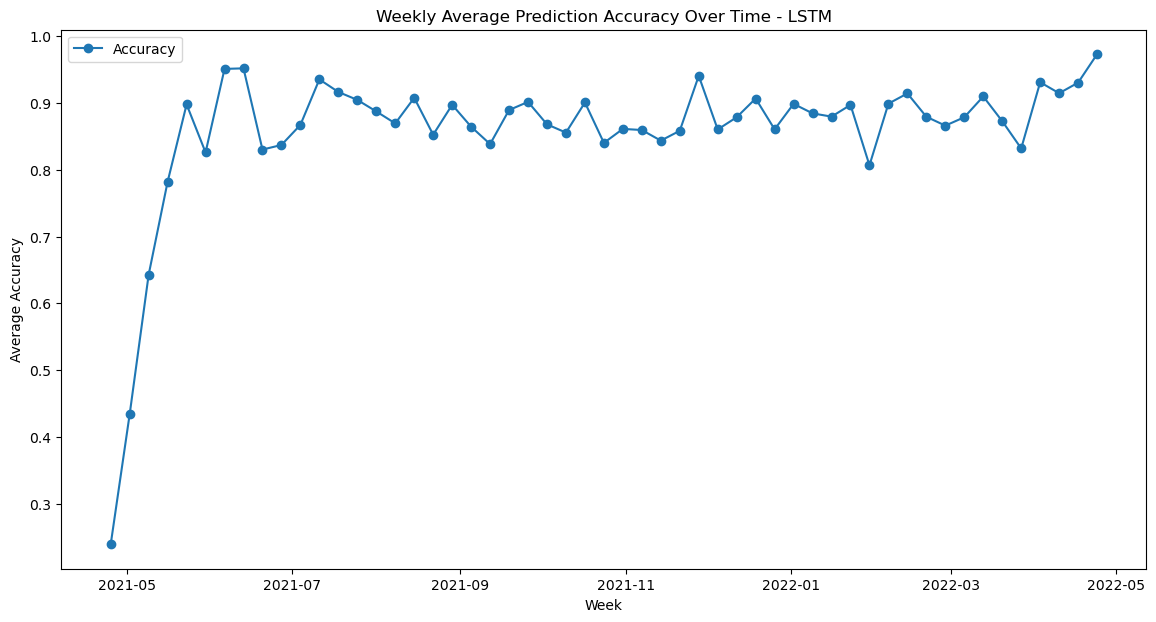

In [45]:
#Accuracy over Time - weekly
results_LSTM_df = pd.DataFrame({
    'event_date': log_data_encoded.loc[X_test.index, 'event_date'],  # Make sure this refers to the correct dates
    'actual_labels': actual_labels_LSTM,
    'predicted_labels': predicted_labels_LSTM
})

results_LSTM_df.index = pd.to_datetime(results_LSTM_df['event_date'])

# Create a new column to store whether each prediction was correct
results_LSTM_df['correct_prediction'] = (results_LSTM_df['actual_labels'] == results_LSTM_df['predicted_labels']).astype(int)

# Calculate weekly accuracy by taking the mean of 'correct_prediction'
weekly_accuracy_LSTM = results_LSTM_df['correct_prediction'].resample('W').mean()

plt.figure(figsize=(14, 7))
plt.plot(weekly_accuracy_LSTM.index, weekly_accuracy_LSTM, label='Accuracy', marker='o')
plt.title('Weekly Average Prediction Accuracy Over Time - LSTM')
plt.xlabel('Week')
plt.ylabel('Average Accuracy')
plt.legend()
plt.show()

              precision    recall  f1-score      support
0              0.000000  0.000000  0.000000     0.000000
1              0.000000  0.000000  0.000000     1.000000
2              0.593301  0.815789  0.686981   152.000000
3              0.833333  0.931677  0.879765   161.000000
4              0.000000  0.000000  0.000000    14.000000
5              0.985000  0.895455  0.938095   440.000000
6              0.770492  0.734375  0.752000    64.000000
7              0.583333  0.636364  0.608696    44.000000
8              0.901408  0.592593  0.715084   108.000000
9              0.000000  0.000000  0.000000     0.000000
10             0.100000  0.500000  0.166667     2.000000
11             0.791001  0.966312  0.869912   564.000000
12             0.952328  0.947426  0.949871  2720.000000
14             0.740950  0.871011  0.800733   752.000000
15             0.994324  0.691903  0.815994  1519.000000
16             0.329949  0.693950  0.447248   281.000000
17             0.166667  0.2857

/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(

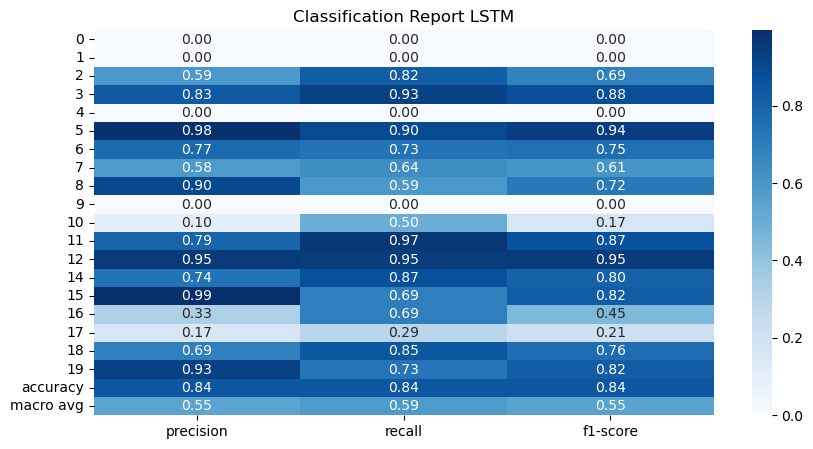

In [46]:
# Classification report
report_LSTM = classification_report(actual_classes_LSTM, y_pred_classes_LSTM, output_dict=True)
report_LSTM_df = pd.DataFrame(report_LSTM).transpose()
print(report_LSTM_df)

plt.figure(figsize=(10, 5))
sns.heatmap(report_LSTM_df.iloc[:-1, :-1], annot=True, fmt=".2f", cmap="Blues")
plt.title('Classification Report LSTM')
plt.show()

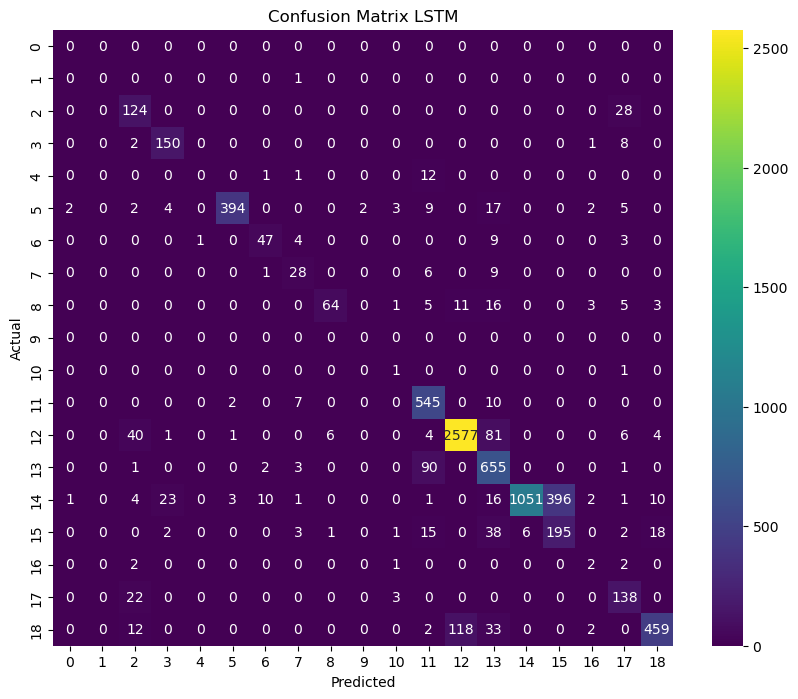

In [80]:
#Confusion Matrix
conf_matrix_LSTM = confusion_matrix(actual_classes_LSTM, y_pred_classes_LSTM)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_LSTM, annot=True, fmt='d', cmap='viridis')  # 'd' for integer format
plt.title('Confusion Matrix LSTM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

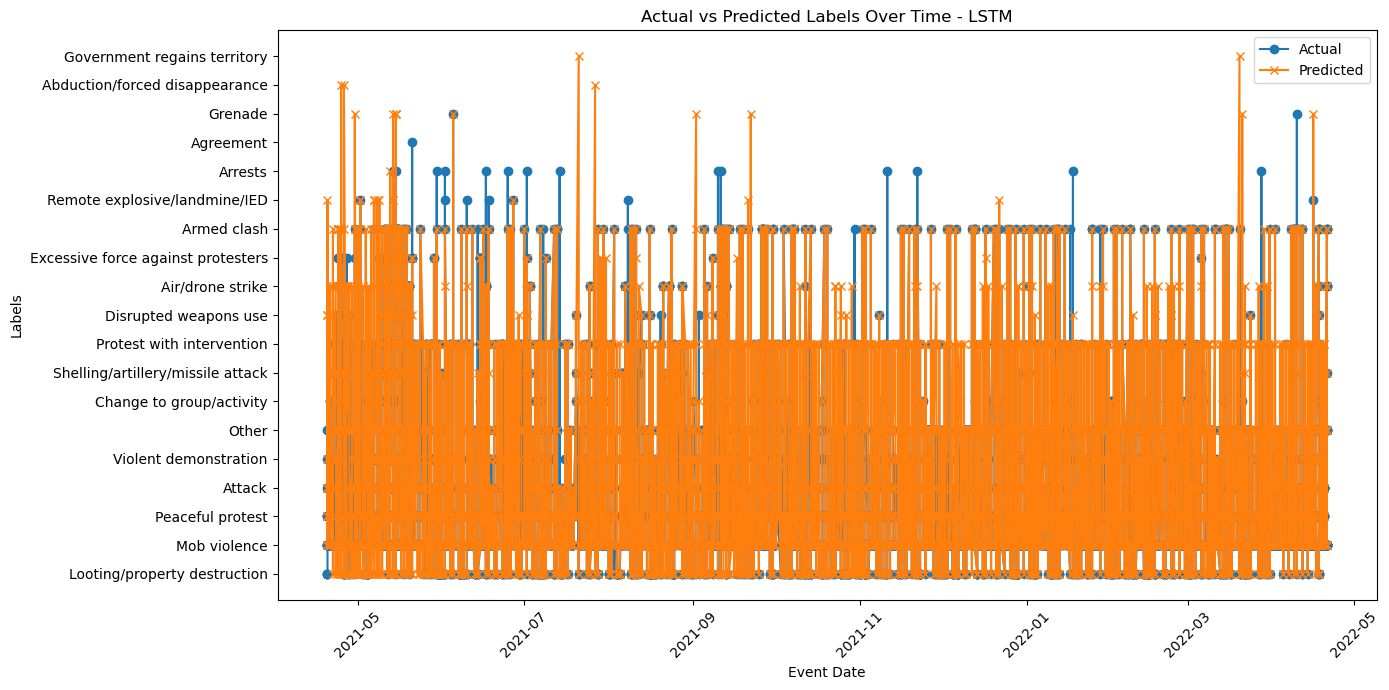

In [48]:
#Time-Series Plot
if 'event_date' in data.columns:
    event_dates_test = data.loc[X_test.index, 'event_date']
    results_LSTM_df = pd.DataFrame({
        'event_date': event_dates_test,
        'actual_labels': label_encoders['sub_event_type'].inverse_transform(actual_classes_LSTM),
        'predicted_labels': label_encoders['sub_event_type'].inverse_transform(y_pred_classes_LSTM)
    })
    results_LSTM_df.sort_values('event_date', inplace=True)

    plt.figure(figsize=(14, 7))
    plt.plot(results_LSTM_df['event_date'], results_LSTM_df['actual_labels'], label='Actual', marker='o')
    plt.plot(results_LSTM_df['event_date'], results_LSTM_df['predicted_labels'], label='Predicted', marker='x')
    plt.title('Actual vs Predicted Labels Over Time - LSTM')
    plt.xlabel('Event Date')
    plt.ylabel('Labels')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [49]:
# LSTM Model without embedding
model_noembed = Sequential()
model_noembed.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_noembed.add(Dropout(0.2))
model_noembed.add(LSTM(50))
model_noembed.add(Dropout(0.2))
model_noembed.add(Dense(y_train_encoded.shape[1], activation='softmax'))

model_noembed.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
model_noembed.fit(X_train, y_train_encoded, epochs=25, batch_size=32, validation_split=0.1)


Epoch 1/25


2024-04-28 20:45:49.118092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 20:45:49.268360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 20:45:49.363194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 20:45:49.505019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/857 [..............................] - ETA: 20:26 - loss: 3.0761 - accuracy: 0.0000e+00

2024-04-28 20:45:49.648895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


855/857 [============================>.] - ETA: 0s - loss: 1.1996 - accuracy: 0.5935

2024-04-28 20:46:13.172335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 20:46:13.248592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 20:46:13.292506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


857/857 [==============================] - 26s 29ms/step - loss: 1.1985 - accuracy: 0.5938 - val_loss: 0.7043 - val_accuracy: 0.6919
Epoch 2/25
857/857 [==============================] - 18s 21ms/step - loss: 0.7247 - accuracy: 0.7410 - val_loss: 0.4738 - val_accuracy: 0.8314
Epoch 3/25
857/857 [==============================] - 19s 22ms/step - loss: 0.5314 - accuracy: 0.8144 - val_loss: 0.2457 - val_accuracy: 0.9183
Epoch 4/25
857/857 [==============================] - 17s 20ms/step - loss: 0.3941 - accuracy: 0.8630 - val_loss: 0.1669 - val_accuracy: 0.9455
Epoch 5/25
857/857 [==============================] - 32s 37ms/step - loss: 0.3193 - accuracy: 0.8857 - val_loss: 0.1742 - val_accuracy: 0.9426
Epoch 6/25
857/857 [==============================] - 24s 28ms/step - loss: 0.2876 - accuracy: 0.8932 - val_loss: 0.1173 - val_accuracy: 0.9682
Epoch 7/25
857/857 [==============================] - 20s 23ms/step - loss: 0.2623 - accuracy: 0.9026 - val_loss: 0.1110 - val_accuracy: 0.9662
Epo

In [52]:
loss_noembed, accuracy_noembed = model_noembed.evaluate(X_test, y_test_encoded)
print(f'Test Accuracy Noembed: {accuracy_noembed:.2f}')
# predictions
y_pred_noembed = model_noembed.predict(X_test)
y_pred_classes_noembed = np.argmax(y_pred_noembed, axis=1)

#actual class
actual_classes_noembed = np.argmax(y_test_encoded, axis=1) if y_test_encoded.ndim > 1 else y_test

#showing errors
errors_noembed = np.where(y_pred_classes_noembed != actual_classes_noembed)[0]
print(f'Number of errors noembed: {len(errors_noembed)} / {len(actual_classes_noembed)}')
for i in errors_noembed[:10]:  # first 10 
    print(f'Index: {i}, Predicted: {y_pred_classes_noembed[i]}, Actual: {actual_classes_noembed[i]}')

239/239 [==============================] - 6s 22ms/step - loss: 1.1309 - accuracy: 0.7876
Test Accuracy Noembed: 0.79
239/239 [==============================] - 2s 10ms/step
Number of errors noembed: 1618 / 7618
Index: 123, Predicted: 11, Actual: 14
Index: 168, Predicted: 10, Actual: 17
Index: 386, Predicted: 18, Actual: 10
Index: 407, Predicted: 11, Actual: 14
Index: 475, Predicted: 11, Actual: 14
Index: 480, Predicted: 11, Actual: 14
Index: 510, Predicted: 11, Actual: 14
Index: 668, Predicted: 11, Actual: 14
Index: 675, Predicted: 16, Actual: 15
Index: 684, Predicted: 11, Actual: 14


In [53]:
predicted_labels_noembed = label_encoders['sub_event_type'].inverse_transform(y_pred_classes_noembed)

actual_labels_noembed = label_encoders['sub_event_type'].inverse_transform(actual_classes_noembed)

for actual, predicted in zip(actual_labels_noembed[:10], predicted_labels_noembed[:10]):
    print(f"Actual: {actual}, Predicted: {predicted}")

Actual: Mob violence, Predicted: Mob violence
Actual: Mob violence, Predicted: Mob violence
Actual: Air/drone strike, Predicted: Air/drone strike
Actual: Shelling/artillery/missile attack, Predicted: Shelling/artillery/missile attack
Actual: Other, Predicted: Other
Actual: Other, Predicted: Other
Actual: Mob violence, Predicted: Mob violence
Actual: Mob violence, Predicted: Mob violence
Actual: Air/drone strike, Predicted: Air/drone strike
Actual: Mob violence, Predicted: Mob violence


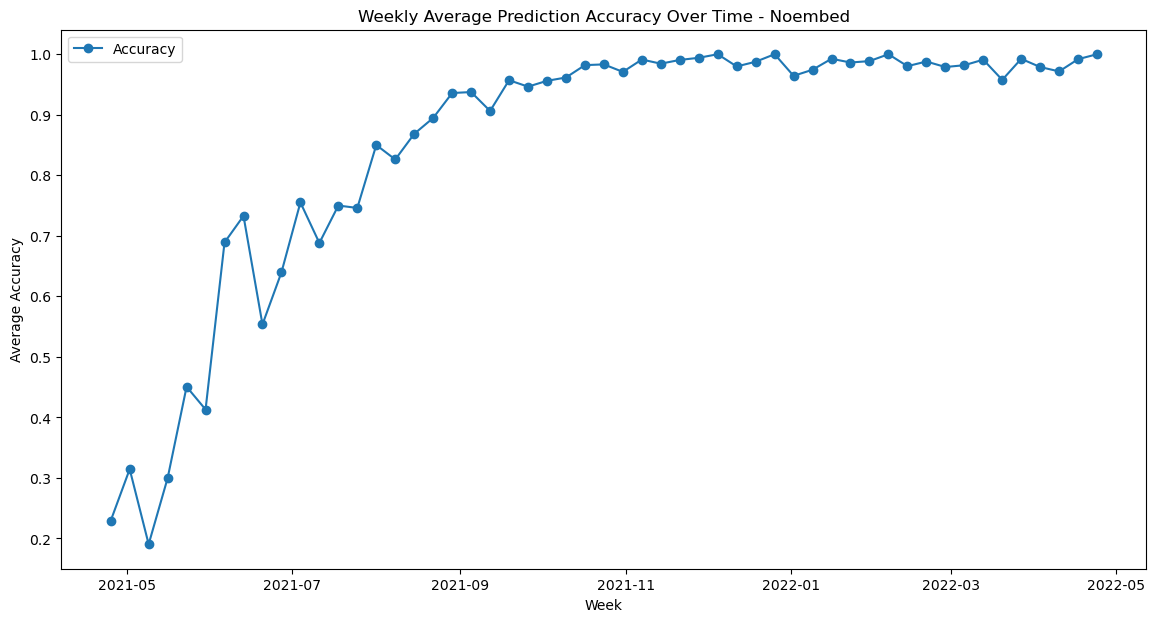

In [54]:
#Accuracy over Time - weekly
results_noembed_df = pd.DataFrame({
    'event_date': log_data_encoded.loc[X_test.index, 'event_date'],  # Make sure this refers to the correct dates
    'actual_labels': actual_labels_noembed,
    'predicted_labels': predicted_labels_noembed
})

results_noembed_df.index = pd.to_datetime(results_noembed_df['event_date'])

# Create a new column to store whether each prediction was correct
results_noembed_df['correct_prediction'] = (results_noembed_df['actual_labels'] == results_noembed_df['predicted_labels']).astype(int)

# Calculate weekly accuracy by taking the mean of 'correct_prediction'
weekly_accuracy_noembed = results_noembed_df['correct_prediction'].resample('W').mean()

plt.figure(figsize=(14, 7))
plt.plot(weekly_accuracy_noembed.index, weekly_accuracy_noembed, label='Accuracy', marker='o')
plt.title('Weekly Average Prediction Accuracy Over Time - Noembed')
plt.xlabel('Week')
plt.ylabel('Average Accuracy')
plt.legend()
plt.show()

/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

              precision    recall  f1-score      support
1              0.000000  0.000000  0.000000     1.000000
2              0.769697  0.835526  0.801262   152.000000
3              0.804020  0.993789  0.888889   161.000000
4              0.000000  0.000000  0.000000    14.000000
5              0.418041  0.979545  0.585996   440.000000
6              0.374101  0.812500  0.512315    64.000000
7              0.275000  0.500000  0.354839    44.000000
8              0.952381  0.185185  0.310078   108.000000
10             0.333333  0.500000  0.400000     2.000000
11             0.627182  0.891844  0.736457   564.000000
12             0.932675  0.763971  0.839935  2720.000000
14             0.725352  0.821809  0.770574   752.000000
15             0.994913  0.901251  0.945769  1519.000000
16             0.953333  0.508897  0.663573   281.000000
17             0.000000  0.000000  0.000000     7.000000
18             0.666667  0.638037  0.652038   163.000000
19             0.896386  0.5942

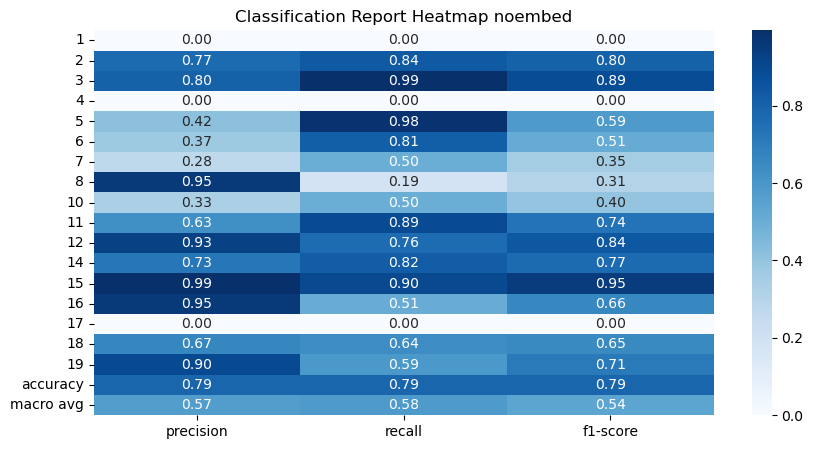

In [55]:
# Classification report
report_noembed = classification_report(actual_classes_noembed, y_pred_classes_noembed, output_dict=True)
report_noembed_df = pd.DataFrame(report_noembed).transpose()
print(report_noembed_df)

plt.figure(figsize=(10, 5))
sns.heatmap(report_noembed_df.iloc[:-1, :-1], annot=True, fmt=".2f", cmap="Blues")
plt.title('Classification Report Heatmap noembed')
plt.show()

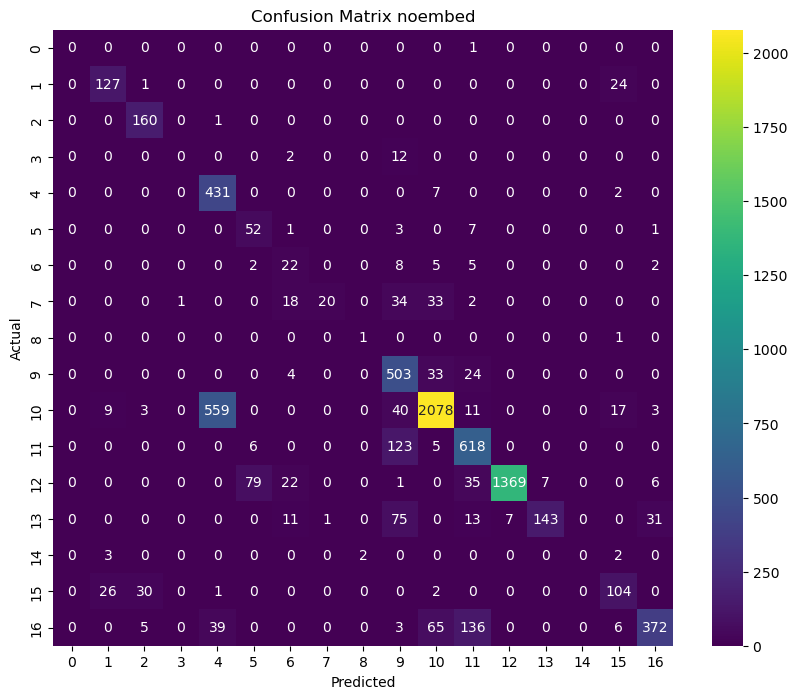

In [56]:
#Confusion Matrix
conf_matrix_noembed = confusion_matrix(actual_classes_noembed, y_pred_classes_noembed)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_noembed, annot=True, fmt='d', cmap='viridis')  # 'd' for integer format
plt.title('Confusion Matrix noembed')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

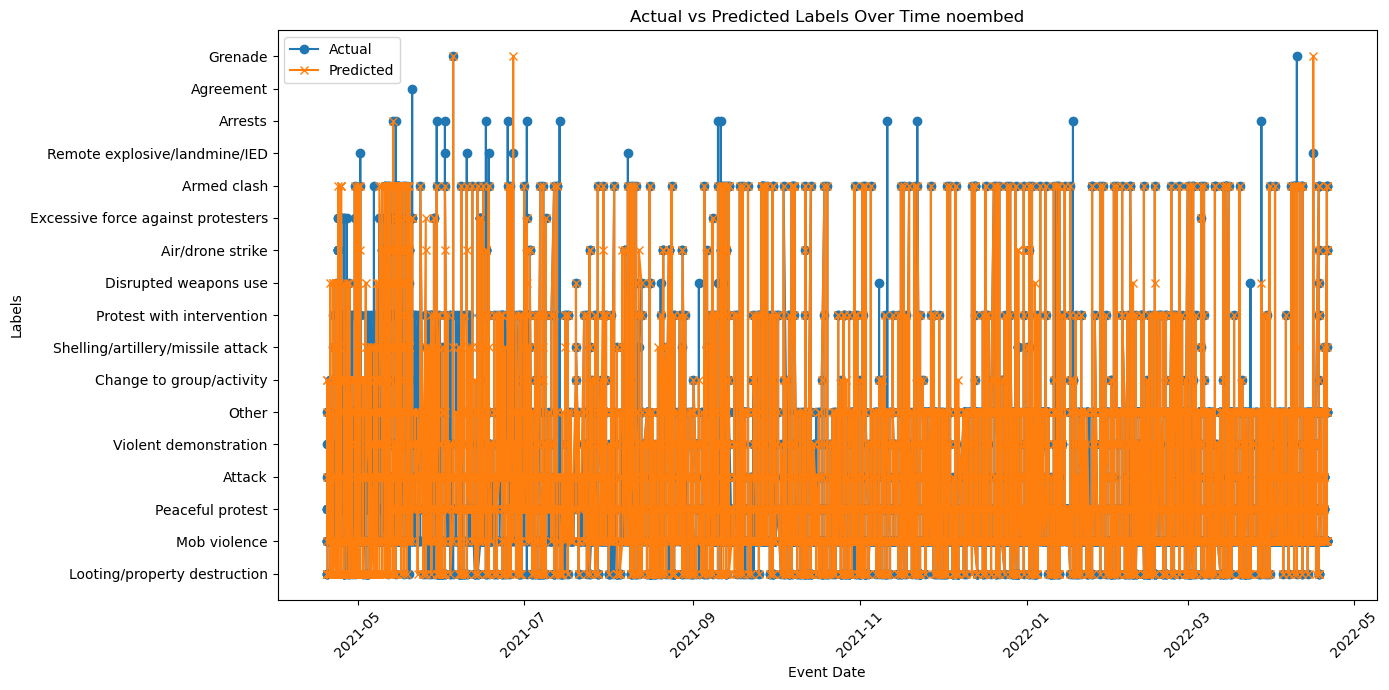

In [57]:
#Time-Series Plot
if 'event_date' in data.columns:
    event_dates_test_noembed = data.loc[X_test.index, 'event_date']
    results_noembed_df = pd.DataFrame({
        'event_date': event_dates_test_noembed,
        'actual_labels': label_encoders['sub_event_type'].inverse_transform(actual_classes_noembed),
        'predicted_labels': label_encoders['sub_event_type'].inverse_transform(y_pred_classes_noembed)
    })
    results_noembed_df.sort_values('event_date', inplace=True)
    
    plt.figure(figsize=(14, 7))
    plt.plot(results_noembed_df['event_date'], results_noembed_df['actual_labels'], label='Actual', marker='o')
    plt.plot(results_noembed_df['event_date'], results_noembed_df['predicted_labels'], label='Predicted', marker='x')
    plt.title('Actual vs Predicted Labels Over Time noembed')
    plt.xlabel('Event Date')
    plt.ylabel('Labels')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [58]:
#Creating OG Dataset (NO FEATURE SELECTION DATASET)

In [59]:
X_original = log_data_encoded.drop(['sub_event_type', 'event_date', 'source', 'notes'], axis=1)
y_original = log_data_encoded['sub_event_type']

X_original_train, X_original_test, y_original_train, y_original_test = train_test_split(X_original, y_original, test_size=0.2, random_state=42, shuffle=False)
y_original_train_encoded = tf.keras.utils.to_categorical(y_original_train)
y_original_test_encoded = tf.keras.utils.to_categorical(y_original_test)

In [60]:
print(X_original_train.shape)
print(X_original_test.shape)
print(y_original_train.shape)
print(y_original_test.shape)
print("Encoded Y")
print(y_original_train_encoded.shape)
print(y_original_test_encoded.shape)
#print(X_original_train.dtypes)

(30472, 151)
(7618, 151)
(30472,)
(7618,)
Encoded Y
(30472, 20)
(7618, 20)


In [61]:
# LSTM Model without embedding and NOT ON SELECTED FEATURES
og_model_noembed = Sequential()
og_model_noembed.add(LSTM(50, return_sequences=True, input_shape=(X_original_train.shape[1], 1)))
og_model_noembed.add(Dropout(0.2))
og_model_noembed.add(LSTM(50))
og_model_noembed.add(Dropout(0.2))
og_model_noembed.add(Dense(y_original_train_encoded.shape[1], activation='softmax'))

og_model_noembed.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
og_model_noembed.fit(X_original_train, y_original_train_encoded, epochs=25, batch_size=32, validation_split=0.1)

Epoch 1/25


2024-04-28 20:55:02.846440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 20:55:03.041111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 20:55:03.165652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 20:55:03.301320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/857 [..............................] - ETA: 23:58 - loss: 2.9992 - accuracy: 0.0625

2024-04-28 20:55:03.584748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


856/857 [============================>.] - ETA: 0s - loss: 2.2730 - accuracy: 0.2144

2024-04-28 20:55:27.201433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 20:55:27.276231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 20:55:27.320944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


857/857 [==============================] - 27s 29ms/step - loss: 2.2730 - accuracy: 0.2144 - val_loss: 2.3330 - val_accuracy: 0.3642
Epoch 2/25
857/857 [==============================] - 29s 33ms/step - loss: 2.2382 - accuracy: 0.2219 - val_loss: 2.3139 - val_accuracy: 0.3642
Epoch 3/25
857/857 [==============================] - 26s 30ms/step - loss: 2.2342 - accuracy: 0.2221 - val_loss: 2.3173 - val_accuracy: 0.3642
Epoch 4/25
857/857 [==============================] - 24s 28ms/step - loss: 2.2315 - accuracy: 0.2221 - val_loss: 2.3560 - val_accuracy: 0.3642
Epoch 5/25
857/857 [==============================] - 30s 35ms/step - loss: 2.2290 - accuracy: 0.2224 - val_loss: 2.2909 - val_accuracy: 0.3642
Epoch 6/25
857/857 [==============================] - 23s 27ms/step - loss: 2.2291 - accuracy: 0.2223 - val_loss: 2.3288 - val_accuracy: 0.3642
Epoch 7/25
857/857 [==============================] - 24s 28ms/step - loss: 2.2229 - accuracy: 0.2244 - val_loss: 2.2984 - val_accuracy: 0.3661
Epo

In [62]:
# Evaluate the model
og_loss_noembed, og_accuracy_noembed = og_model_noembed.evaluate(X_original_test, y_original_test_encoded)
print(f'Test Accuracy for original non-embedding model: {og_accuracy_noembed:.2f}')

# predictions
og_y_pred_noembed = og_model_noembed.predict(X_original_test)
og_y_pred_classes_noembed = np.argmax(og_y_pred_noembed, axis=1)

#actual class
og_actual_classes_noembed = np.argmax(y_original_test_encoded, axis=1)

#showing errors
og_errors_noembed = np.where(og_y_pred_classes_noembed != og_actual_classes_noembed)[0]
print(f'Number of errors in original non-embedding model: {len(og_errors_noembed)} / {len(og_actual_classes_noembed)}')
for i in og_errors_noembed[:10]:  # first 10 
    print(f'Index: {i}, Predicted: {og_y_pred_classes_noembed[i]}, Actual: {og_actual_classes_noembed[i]}')

239/239 [==============================] - 4s 16ms/step - loss: 2.3437 - accuracy: 0.3135
Test Accuracy for original non-embedding model: 0.31
  1/239 [..............................] - ETA: 1:38

2024-04-28 21:05:42.403750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 21:05:42.474254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 21:05:42.531571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - 3s 10ms/step
Number of errors in original non-embedding model: 5230 / 7618
Index: 2, Predicted: 12, Actual: 2
Index: 3, Predicted: 12, Actual: 18
Index: 4, Predicted: 12, Actual: 14
Index: 5, Predicted: 12, Actual: 14
Index: 8, Predicted: 12, Actual: 2
Index: 11, Predicted: 12, Actual: 14
Index: 12, Predicted: 12, Actual: 3
Index: 13, Predicted: 12, Actual: 3
Index: 14, Predicted: 12, Actual: 14
Index: 15, Predicted: 12, Actual: 3


In [63]:
og_predicted_labels_noembed = label_encoders['sub_event_type'].inverse_transform(og_y_pred_classes_noembed)

og_actual_labels_noembed = label_encoders['sub_event_type'].inverse_transform(og_actual_classes_noembed)

for actual, predicted in zip(og_actual_labels_noembed[:10], og_predicted_labels_noembed[:10]):
    print(f"Actual: {actual}, Predicted: {predicted}")

Actual: Mob violence, Predicted: Mob violence
Actual: Mob violence, Predicted: Mob violence
Actual: Air/drone strike, Predicted: Mob violence
Actual: Shelling/artillery/missile attack, Predicted: Mob violence
Actual: Other, Predicted: Mob violence
Actual: Other, Predicted: Mob violence
Actual: Mob violence, Predicted: Mob violence
Actual: Mob violence, Predicted: Mob violence
Actual: Air/drone strike, Predicted: Mob violence
Actual: Mob violence, Predicted: Mob violence


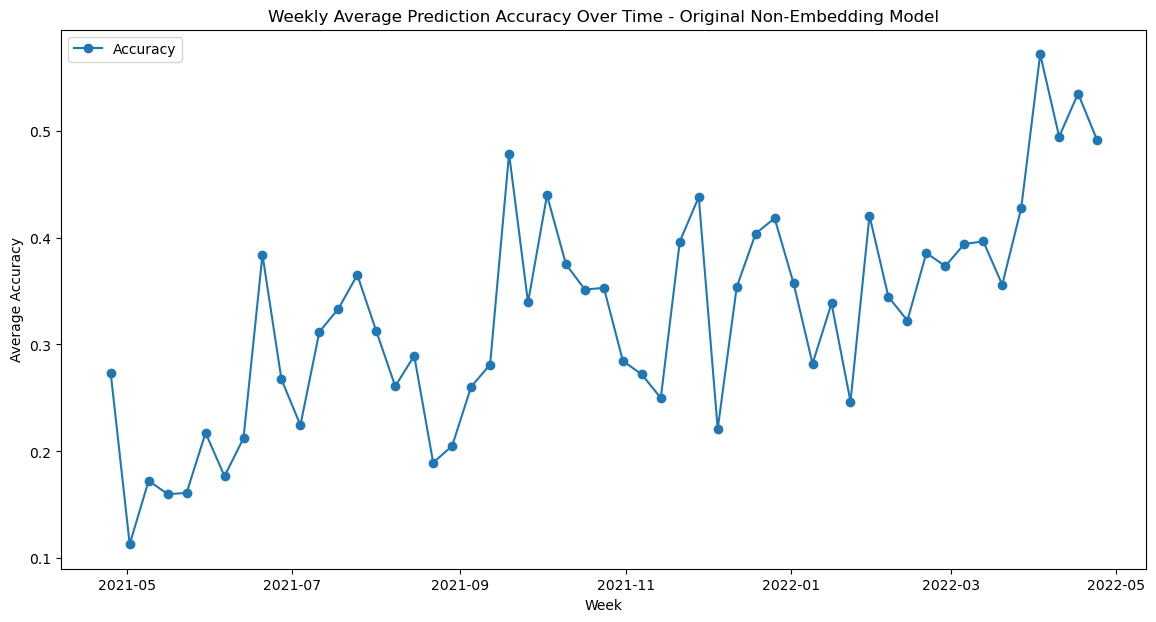

In [64]:
#Accuracy over Time - weekly
og_results_noembed_df = pd.DataFrame({
    'event_date': log_data_encoded.loc[X_original_test.index, 'event_date'],
    'actual_labels': og_actual_labels_noembed,  
    'predicted_labels': og_predicted_labels_noembed  
})

#datetime index
og_results_noembed_df.index = pd.to_datetime(og_results_noembed_df['event_date'])

#was each prediction was correct?
og_results_noembed_df['correct_prediction'] = (og_results_noembed_df['actual_labels'] == og_results_noembed_df['predicted_labels']).astype(int)

# weekly accuracy by taking the mean of 'correct_prediction'
weekly_accuracy_og_noembed = og_results_noembed_df['correct_prediction'].resample('W').mean()

plt.figure(figsize=(14, 7))
plt.plot(weekly_accuracy_og_noembed.index, weekly_accuracy_og_noembed, label='Accuracy', marker='o')
plt.title('Weekly Average Prediction Accuracy Over Time - Original Non-Embedding Model')
plt.xlabel('Week')
plt.ylabel('Average Accuracy')
plt.legend()
plt.show()

              precision    recall  f1-score      support
1              0.000000  0.000000  0.000000     1.000000
2              0.139831  0.651316  0.230233   152.000000
3              0.000000  0.000000  0.000000   161.000000
4              0.000000  0.000000  0.000000    14.000000
5              0.000000  0.000000  0.000000   440.000000
6              0.000000  0.000000  0.000000    64.000000
7              0.000000  0.000000  0.000000    44.000000
8              0.000000  0.000000  0.000000   108.000000
10             0.000000  0.000000  0.000000     2.000000
11             0.000000  0.000000  0.000000   564.000000
12             0.339761  0.783824  0.474041  2720.000000
14             0.000000  0.000000  0.000000   752.000000
15             0.247244  0.103357  0.145775  1519.000000
16             0.000000  0.000000  0.000000   281.000000
17             0.000000  0.000000  0.000000     7.000000
18             0.000000  0.000000  0.000000   163.000000
19             0.000000  0.0000

/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

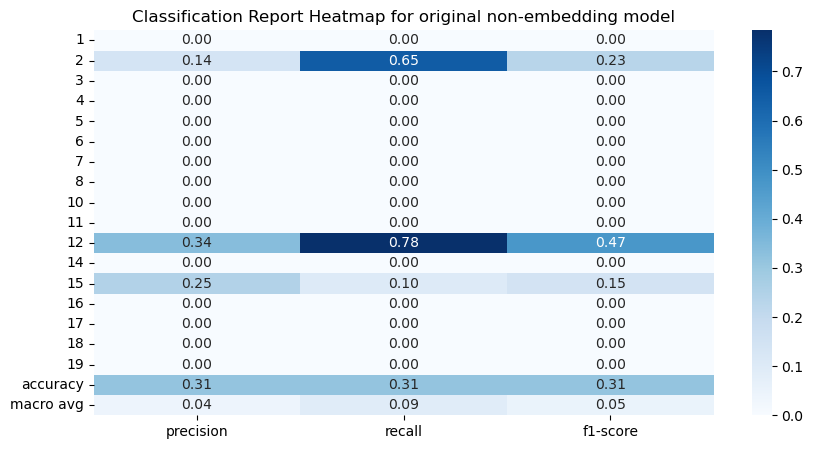

In [65]:
# Classification report
og_report_noembed = classification_report(og_actual_classes_noembed, og_y_pred_classes_noembed, output_dict=True)
og_report_noembed_df = pd.DataFrame(og_report_noembed).transpose()
print(og_report_noembed_df)

plt.figure(figsize=(10, 5))
sns.heatmap(og_report_noembed_df.iloc[:-1, :-1], annot=True, fmt=".2f", cmap="Blues")
plt.title('Classification Report Heatmap for original non-embedding model')
plt.show()

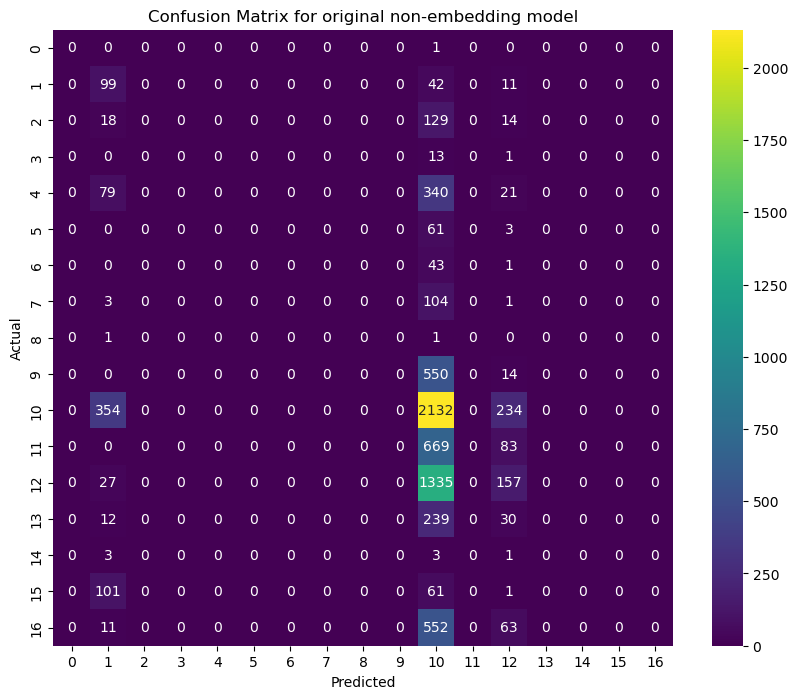

In [66]:
#Confusion Matrix
og_conf_matrix_noembed = confusion_matrix(og_actual_classes_noembed, og_y_pred_classes_noembed)
plt.figure(figsize=(10, 8))
sns.heatmap(og_conf_matrix_noembed, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix for original non-embedding model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

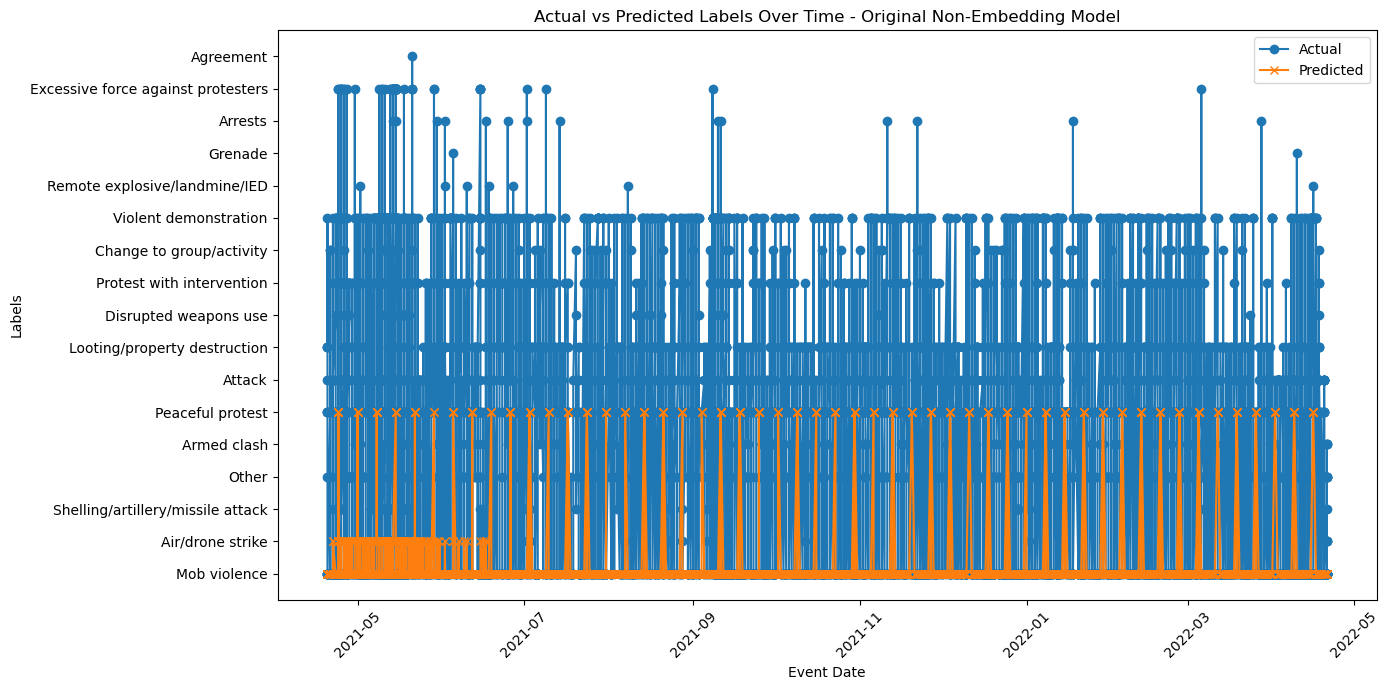

In [73]:
# Set 'event_date' as the index if it isn't already
if 'event_date' not in og_results_noembed_df.index.names:
    og_results_noembed_df.set_index('event_date', inplace=True)

# Convert the index to datetime if it's not already
og_results_noembed_df.index = pd.to_datetime(og_results_noembed_df.index)

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(og_results_noembed_df.index, og_results_noembed_df['actual_labels'], label='Actual', marker='o')
plt.plot(og_results_noembed_df.index, og_results_noembed_df['predicted_labels'], label='Predicted', marker='x')
plt.title('Actual vs Predicted Labels Over Time - Original Non-Embedding Model')
plt.xlabel('Event Date')
plt.ylabel('Labels')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
#VAR Model?

In [ ]:
#Prophet Model
from prophet import Prophet


In [ ]:
#ARIMA? #VECM? Need ONE MORE MODEL

In [ ]:
#Need to add plots for my paper. What types of plots can I create to convey my time-series prediction of 'sub_event_type'?